In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit.als import AlternatingLeastSquares
from implicit.nearest_neighbours import bm25_weight, tfidf_weight

# Функции из 1-ого вебинара
from metrics import precision_at_k, recall_at_k

# warnings.filterwarnings('ignore')

In [94]:
data = pd.read_csv('02_Data/retail_train.csv')

data.columns = [col.lower() for col in data.columns]
data.rename(columns={'household_key': 'user_id',
                    'product_id': 'item_id'},
           inplace=True)
data.shape

(2396804, 12)

In [95]:
data.item_id.nunique()

89051

In [3]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

data_train.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0
5,2375,26984851516,1,826249,2,1.98,364,-0.60,1642,1,0.0,0.0
6,2375,26984851516,1,1043142,1,1.57,364,-0.68,1642,1,0.0,0.0
7,2375,26984851516,1,1085983,1,2.99,364,-0.40,1642,1,0.0,0.0
8,2375,26984851516,1,1102651,1,1.89,364,0.00,1642,1,0.0,0.0
9,2375,26984851516,1,6423775,1,2.00,364,-0.79,1642,1,0.0,0.0


In [4]:
item_features = pd.read_csv('02_Data/product.csv')
item_features.columns = [col.lower() for col in item_features.columns]
item_features.rename(columns={'product_id': 'item_id'}, inplace=True)

item_features.head()

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ


In [5]:
item_features.department.unique()

array(['GROCERY', 'MISC. TRANS.', 'PASTRY', 'DRUG GM', 'MEAT-PCKGD',
       'SEAFOOD-PCKGD', 'PRODUCE', 'NUTRITION', 'DELI', 'COSMETICS',
       'MEAT', 'FLORAL', 'TRAVEL & LEISUR', 'SEAFOOD', 'MISC SALES TRAN',
       'SALAD BAR', 'KIOSK-GAS', 'ELECT &PLUMBING', 'GRO BAKERY',
       'GM MERCH EXP', 'FROZEN GROCERY', 'COUP/STR & MFG', 'SPIRITS',
       'GARDEN CENTER', 'TOYS', 'CHARITABLE CONT', 'RESTAURANT', 'RX',
       'PROD-WHS SALES', 'MEAT-WHSE', 'DAIRY DELI', 'CHEF SHOPPE', 'HBC',
       'DELI/SNACK BAR', 'PORK', 'AUTOMOTIVE', 'VIDEO RENTAL', ' ',
       'CNTRL/STORE SUP', 'HOUSEWARES', 'POSTAL CENTER', 'PHOTO', 'VIDEO',
       'PHARMACY SUPPLY'], dtype=object)

In [6]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [7]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [8]:
data_train.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [11]:
# Заведем фиктивный item_id

data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity', # Можно пробовать другие варианты
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix)

user_item_matrix.head()

/home/foreman/anaconda3/envs/recommender_systems/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

# ALS

In [21]:
%%time
# import mkl
# mkl.set_num_threads(4)


model = AlternatingLeastSquares(factors=100,
                                regularization=0.001,
                                iterations=15,
                                calculate_training_loss=True,
                                num_threads=4)

model.fit(sparse_user_item.T.tocsr(),  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                       user_items=sparse_user_item,   # на вход user-item matrix
                       N=5, # кол-во рекомендаций 
                       filter_already_liked_items=False,
                       filter_items=None,
                       recalculate_user=True)

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 17.9 s, sys: 148 ms, total: 18.1 s
Wall time: 3.04 s


In [23]:
recs

[(4016, 1.0759868254788683),
 (3688, 1.0240149575935629),
 (2381, 0.9966270801795178),
 (4157, 0.9948635073005023),
 (3408, 0.928649437926527)]

In [22]:
[id_to_itemid[rec[0]] for rec in recs]

[1133018, 1106523, 999999, 5569230, 1082185]

In [24]:
def get_recommendations(user, model, N=5):
    res = [id_to_itemid[rec[0]] for rec in 
                    model.recommend(userid=userid_to_id[user], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=N, 
                                    filter_already_liked_items=False, 
                                    filter_items=None, 
                                    recalculate_user=True)]
    return res

In [25]:
%%time
    
result['als'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

result.apply(lambda row: precision_at_k(row['als'], row['actual']), axis=1).mean()

CPU times: user 1min 29s, sys: 1.18 s, total: 1min 30s
Wall time: 15.1 s


0.16248775710088154

In [28]:
result.head(2)

,user_id,actual,als
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[979707, 1033142, 986912, 995242, 5569374]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1106523, 914190, 909894, 5568378, 1133018]"


In [30]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

def reduce_dims(df, dims=2, method='pca'):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        pca = PCA(n_components=dims)
        components = pca.fit_transform(df)
    elif method == 'tsne':
        tsne = TSNE(n_components=dims, learning_rate=250, random_state=42)
        components = tsne.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return pd.DataFrame(data = components, columns = colnames) 


def display_components_in_2D_space(components_df, labels='category', marker='D'):
    
    groups = components_df.groupby(labels)

    # Plot
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
    for name, group in groups:
        ax.plot(group.component_1, group.component_2, 
                marker='o', ms=6,
                linestyle='',
                alpha=0.7,
                label=name)
    ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5))

    plt.xlabel('component_1')
    plt.ylabel('component_2') 
    plt.show()

In [34]:
model.item_factors.shape

(5001, 100)

In [44]:
category = []

for idx in range(model.item_factors.shape[0]):

    try:
        cat = item_features.loc[item_features['item_id'] == id_to_itemid[idx], 'department'].values[0]
        category.append(cat)
    except:
        category.append('UNKNOWN')

In [45]:
print(category[:10])

['MISC SALES TRAN', 'KIOSK-GAS', 'MISC SALES TRAN', 'KIOSK-GAS', 'MISC SALES TRAN', 'MISC SALES TRAN', 'KIOSK-GAS', 'GROCERY', 'GROCERY', 'GROCERY']


In [49]:
%%time
item_emb_tsne = reduce_dims(model.item_factors, dims=2, method='tsne') # 5001 х 100  ---> 5001 x 2
item_emb_tsne['category'] = category  # Добавляем категорию
item_emb_tsne = item_emb_tsne[item_emb_tsne['category'] != 'UNKNOWN']
item_emb_tsne.head(2)

,component_1,component_2,category
0,-9.513199,3.063165,MISC SALES TRAN
1,-9.459525,6.773884,KIOSK-GAS


Отобразим имеющиеся категории товаров на двумерную плоскость

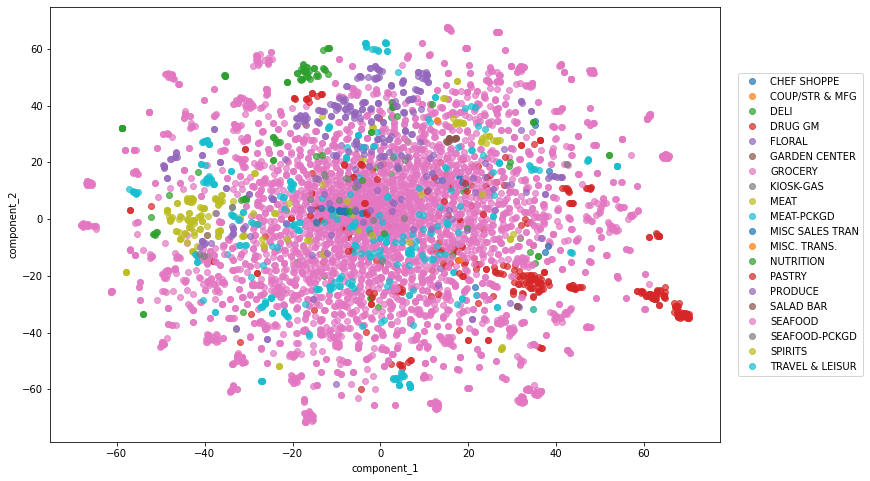

CPU times: user 2min 23s, sys: 2.37 s, total: 2min 25s
Wall time: 13 s


In [46]:
display_components_in_2D_space(item_emb_tsne, labels='category')

Отобразим все, кроме GROCERY

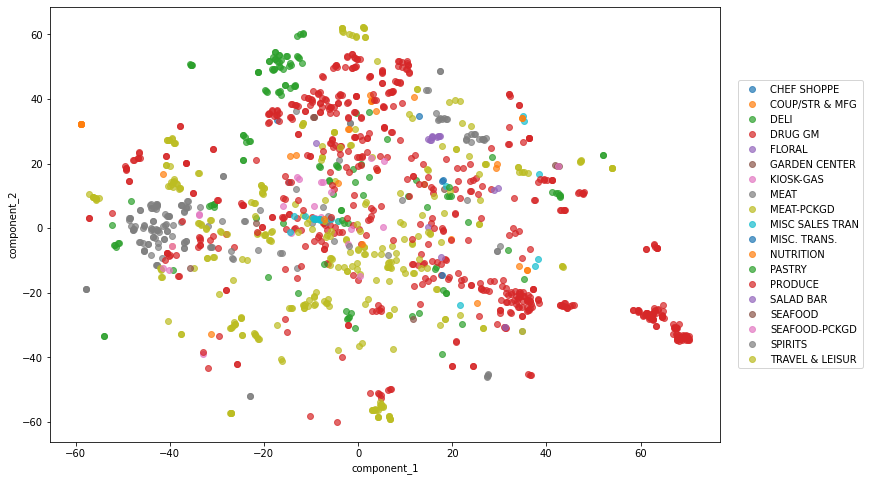

In [47]:
display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'] != 'GROCERY'], labels='category')

Отобразим несколько конкретных категорий

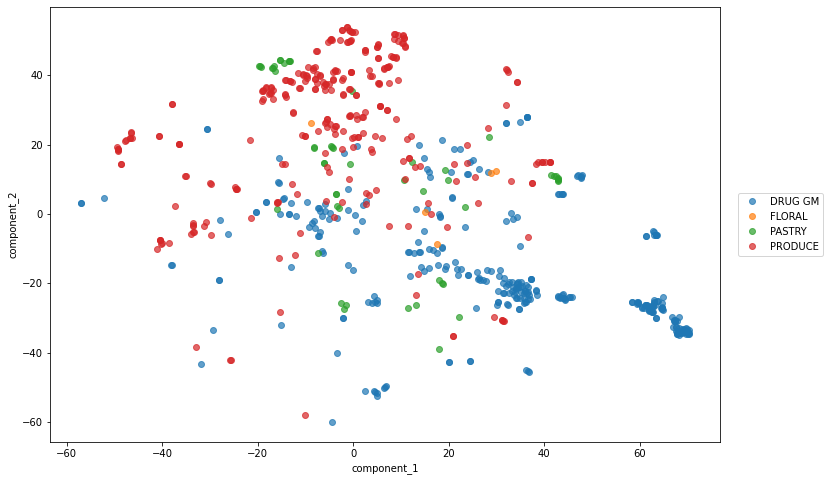

In [48]:
interesting_cats = ['PASTRY', 'PRODUCE', 'DRUG GM', 'FLORAL']

display_components_in_2D_space(item_emb_tsne[item_emb_tsne['category'].isin(interesting_cats)], 
                               labels='category')

recommend_all делает перемножение, но еще и сортирует и выбирает топ-N

In [50]:
%%time
recommendations = model.recommend_all(N=5, 
                                      user_items=sparse_user_item,
                                      filter_already_liked_items=True, 
                                      filter_items=None, 
                                      recalculate_user=True,
                                      show_progress=True,
                                      batch_size=500)

  0%|          | 0/2499 [00:00<?, ?it/s]

CPU times: user 22.7 s, sys: 249 ms, total: 22.9 s
Wall time: 14.4 s


In [51]:
recommendations.shape

(2499, 5)

In [52]:
recommendations

array([[ 832, 1927, 3031,  912, 3643],
       [2148,  215, 2927,  558, 4346],
       [1516, 3388, 3029, 2765, 1242],
       ...,
       [4346, 3587, 2148, 3133,  558],
       [2847,  845,  300, 4016,  657],
       [ 558, 2454, 4060, 2216, 3688]], dtype=int32)

*Посмотрите также / Похожие товары*

In [59]:
example_item_row_id = 3606

In [60]:
id_to_itemid[example_item_row_id]

1100265

In [61]:
closest_items = [id_to_itemid[row_id] for row_id, score in model.similar_items(example_item_row_id, N=5)]

In [62]:
item_features[item_features.item_id.isin(closest_items)]

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
6109,821735,2186,MEAT-PCKGD,National,LUNCHMEAT,HAM,2.5 OZ
32127,1051626,69,GROCERY,Private,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ
37579,1100265,69,GROCERY,Private,CHEESE,NATURAL CHEESE EXACT WT SLICES,10 OZ
39005,1113385,693,DRUG GM,National,CANDY - PACKAGED,SEASONAL CANDY BAGS-CHOCOLATE,13 OZ
75846,12352293,1266,GROCERY,National,FLOUR & MEALS,FLOUR: WHITE & SELF RISING,5 LB


*Вашим друзьям нравится / Похожим пользователям нравится / ...*

Пользователь --> похожих пользовтелей --> рекомендовать те товары, которые купили похожие юзеры

In [63]:
model.similar_users(userid_to_id[10], N=5)

[(9, 1.0000001),
 (239, 0.9737328),
 (1380, 0.9721928),
 (790, 0.971723),
 (354, 0.97086185)]

### 2. TF-IDF взвешивание

In [64]:
user_item_matrix = tfidf_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [65]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4)

model.fit(sparse_user_item.T.tocsr(),  # На вход item-user matrix
          show_progress=True)

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 17.3 s, sys: 124 ms, total: 17.4 s
Wall time: 2.93 s


In [66]:
result['als_tfidf'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

result.apply(lambda row: precision_at_k(row['als_tfidf'], row['actual']), axis=1).mean()

0.16199804113614105

### 3. BM25 взвешивание

In [68]:
user_item_matrix = bm25_weight(user_item_matrix.T).T  # Применяется к item-user матрице ! 

In [71]:
%%time

model = AlternatingLeastSquares(factors=100, 
                                regularization=0.001,
                                iterations=15, 
                                calculate_training_loss=True, 
                                num_threads=4) # K - кол-во билжайших соседей

model.fit(sparse_user_item.T.tocsr(),  # На вход item-user matrix
          show_progress=True)

  0%|          | 0/15 [00:00<?, ?it/s]

CPU times: user 16.6 s, sys: 103 ms, total: 16.7 s
Wall time: 2.82 s


In [73]:
result['als_bm25'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

result.apply(lambda row: precision_at_k(row['als_bm25'], row['actual']), axis=1).mean()

0.1629774730656219

In [72]:
result.head()

,user_id,actual,als,als_tfidf,als_bm25
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[979707, 1033142, 986912, 995242, 5569374]","[1033142, 986912, 999999, 1082185, 995242]","[965766, 1033142, 5569374, 1105488, 1029743]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[1106523, 914190, 909894, 5568378, 1133018]","[1133018, 1106523, 951590, 999999, 883404]","[1133018, 965766, 910032, 938700, 1106523]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1007195, 1051516, 866211, 986912, 904360]","[1023720, 866211, 1024306, 1051516, 1007195]","[1007195, 1023720, 866211, 878996, 820165]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[1058997, 1126899, 938700, 999999, 1133018]","[999999, 1082185, 1058997, 826249, 849843]","[999999, 1106523, 1082185, 1133018, 1126899]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[1004906, 1068719, 938700, 844179, 965766]","[1053690, 979707, 1133018, 938700, 833715]","[844179, 1004906, 1044078, 833715, 938700]"


In [76]:
import os
os.makedirs('predictions', exist_ok=True)

result.to_csv('predictions/predictions_mf.csv', index=False)  # mf - matrix factorization

In [77]:
data_train.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [78]:
data_train['price'] = data_train['sales_value'] / (np.maximum(data_train['quantity'], 1))
data_train['price'].max()

<ipython-input-78-73e31537f690>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_train['price'] = data_train['sales_value'] / (np.maximum(data_train['quantity'], 1))


499.99

In [79]:
# < 1$
data_train['price'].quantile(0.20)

0.99

In [80]:
# > 100$
data_train['price'].quantile(0.99995)

82.01435450003483

In [90]:
popularity = data_train.groupby('item_id')['user_id'].nunique().reset_index()
popularity.rename(columns={'user_id': 'share_unique_users'}, inplace=True)
popularity['share_unique_users'] = popularity['share_unique_users'] / data_train['user_id'].nunique()
popularity['share_unique_users'].describe()

count    5001.000000
mean        0.053377
std         0.054696
min         0.000400
25%         0.027211
50%         0.038816
75%         0.058423
max         0.999600
Name: share_unique_users, dtype: float64

In [98]:
# получим список самых популярных товаров включая item_id = 999999, но в перечне реальных товаров его нет
popular_items = popularity[popularity['share_unique_users'] > .5]['item_id'].tolist()
item_features[item_features['item_id'].isin(popular_items)]

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
6677,826249,69,GROCERY,Private,BAKED BREAD/BUNS/ROLLS,HAMBURGER BUNS,12 OZ
8281,840361,69,GROCERY,Private,EGGS,EGGS - LARGE,1 DZ
24250,981760,69,GROCERY,Private,EGGS,EGGS - X-LARGE,1 DZ
25754,995242,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,
29657,1029743,69,GROCERY,Private,FLUID MILK PRODUCTS,FLUID MILK WHITE ONLY,1 GA
35576,1082185,2,PRODUCE,National,TROPICAL FRUIT,BANANAS,40 LB
37359,1098066,69,GROCERY,Private,BAKED BREAD/BUNS/ROLLS,HOT DOG BUNS,11 OZ
40600,1127831,5937,PRODUCE,National,BERRIES,STRAWBERRIES,16 OZ
57221,6534178,69,KIOSK-GAS,Private,COUPON/MISC ITEMS,GASOLINE-REG UNLEADED,


In [138]:
zero_item_id = data[data['sales_value'] == 0].item_id.unique().tolist()
len(zero_item_id)

5010

In [107]:
item_features[item_features['item_id'].isin(zero_item_id)]

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
142,30937,693,DRUG GM,National,CANDY - PACKAGED,CANDY BARS (MULTI PACK),6 PK
159,31563,97,DRUG GM,National,SHAVING CARE PRODUCTS,MENS HAIR SPRAYS/TONICS/CREAMS,
1693,89569,638,GROCERY,National,FROZEN PIE/DESSERTS,FROZEN FRUIT PIES & COBBLERS,40 OZ
2156,108623,97,DRUG GM,National,SHAVING CARE PRODUCTS,MENS HAIR SPRAYS/TONICS/CREAMS,
2159,108646,450,NUTRITION,National,REFRIGERATED,SOY/RICE MILK,64 OZ
...,...,...,...,...,...,...,...
91419,17284401,895,MISC. TRANS.,Private,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,
91485,17291184,584,GROCERY,National,CONVENIENT BRKFST/WHLSM SNACKS,GRANOLA BARS,8.4 OZ
91499,17291554,6128,DRUG GM,National,SPRING/SUMMER SEASONAL,CHARCOAL GRILLS,
91541,17320698,6383,DRUG GM,National,BOOKSTORE,HARDBACK/TRADE EVERYDAY,


In [101]:
# получим список самых популярных товаров включая item_id = 999999, но в перечне реальных товаров его нет
popular_items = popularity[popularity['share_unique_users'] < .01]['item_id'].tolist()
item_features[item_features['item_id'].isin(popular_items)].item_id.nunique()

126

In [ ]:
def prefilter_items(data):
    # Уберем самые популярные товары (их и так купят)
    popularity = data_train.groupby('item_id')['user_id'].nunique().reset_index() / data_train['user_id'].nunique()
    popularity.rename(columns={'user_id': 'share_unique_users'}, inplace=True)
    
    top_popular = popularity[popularity['share_unique_users'] > 0.5].item_id.tolist()
    data = data[~data['item_id'].isin(top_popular)]
    
    # Уберем самые НЕ популярные товары (их и так НЕ купят)
    top_notpopular = popularity[popularity['share_unique_users'] < 0.01].item_id.tolist()
    data = data[~data['item_id'].isin(top_notpopular)]
    
    # Уберем товары, которые не продавались за последние 12 месяцев
    
    # Уберем не интересные для рекоммендаций категории (department)
    
    # Уберем слишком дешевые товары (на них не заработаем). 1 покупка из рассылок стоит 60 руб. 
    
    # Уберем слишком дорогие товарыs
    
    # ...
    
def postfilter_items(user_id, recommednations):
    pass

In [115]:
gs_result = pd.DataFrame(columns=['factors', 'regularization', 'iterations', 'mean_precision@5'])
gs_result

,factors,regularization,iterations,mean_precision@5


In [ ]:
factors_list = [50, 75, 100, 125, 150, 175, 200, 225, 250]
regularizations_list = [.1e-03, .1e-02, .5e-02, .1e-01]
iterations_list = [5, 9, 12, 15, 17, 19, 21]

gs_result = pd.DataFrame(columns=['factors', 'regularization', 'iterations', 'mean_precision@5'])
result.drop(columns='test', inplace=True, errors='ignore')

for factor in factors_list:
    for regularization in regularizations_list:
        for iteration in iterations_list:
            model = AlternatingLeastSquares(factors=factor,
                                            regularization=regularization,
                                            iterations=iteration,
                                            calculate_training_loss=True,
                                            num_threads=4)

            model.fit(sparse_user_item.T.tocsr(),  # На вход item-user matrix
                      show_progress=False)

            result['test'] = result['user_id'].apply(lambda x: get_recommendations(x, model=model, N=5))

            gs_result = gs_result.append({'factors': factor,
                                          'regularization': regularization,
                                          'iterations': iteration,
                                          'mean_precision@5': result.apply(
                                              lambda row: precision_at_k(row['test'], row['actual']),
                                              axis=1
                                          ).mean()
                                         }, ignore_index=True)

In [132]:
gs_result.sort_values(by='mean_precision@5', ascending=False).head(20)

,factors,regularization,iterations,mean_precision@5
42,75.0,0.0050,5.0,0.173457
49,75.0,0.0100,5.0,0.172576
14,50.0,0.0050,5.0,0.171596
7,50.0,0.0010,5.0,0.171009
21,50.0,0.0100,5.0,0.170715
105,125.0,0.0100,5.0,0.169638
23,50.0,0.0100,12.0,0.169540
9,50.0,0.0010,12.0,0.169540
56,100.0,0.0001,5.0,0.169148
11,50.0,0.0010,17.0,0.169050
